In [6]:

#-----------------------------------------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")
import time as t
from datetime import datetime, timedelta, date 
from dateutil.relativedelta import *
from netCDF4 import Dataset   
import glob
import requests 
import pandas as pd
import xarray as xr
import requests 
import functools
import operator
import wget
import os
import gc
import numpy as np
import pygrib
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
import datetime
import holidays
import xarray as xr
from scipy.interpolate import griddata


import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import shapefile
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import cartopy, cartopy.crs as ccrs   
import regionmask
from shapely.geometry import Point, Polygon

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker 
import scipy.ndimage as ndimage
from PIL import Image
from glob import glob

import matplotlib.colors as colors
import matplotlib

import urllib.request
from metpy.units import units



#-----METPY---------------------
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.interpolate import cross_section
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [21]:
# Download data

#Loop para puxar os dados 
rodadas = []
#atual
data_atual = datetime.datetime.now().date()

# for i in range(6):

#     data = data_atual - datetime.timedelta(days=i)
    
#     # horários 
#     for hora in [0]:
#         data_hora = datetime.datetime.combine(data, datetime.time(hora))
#         data_hora = data_hora.strftime('%Y%m%d')
#         rodadas.append(data_hora)
#         # print(data_hora)

# print(rodadas)     



# print('------------------------------------')
# print(' Download Data ')
# print('------------------------------------')

# rodadas
# rodada = '00' 
# membros = ['01']


#--------------------------------PSI em 200 hPa ---------------------
# for d in rodadas:

#     for membro in membros:
#         #  
#         path = f"https://ftp.ncep.noaa.gov/data/nccf/com/cfs/prod/cfs.{d}/{rodada}/time_grib_{membro}/psi200.{membro}.{d}{rodada}.daily.grb2"
#         # Nome do arquivo para salvar
#         filename = f"dados_grib/psi200_{membro}_{d}{rodada}.grb2"
#         # Baixar o arquivo usando a biblioteca urllib.request
#         urllib.request.urlretrieve(path, filename)
#         print(f"Arquivo {filename} baixado")


In [3]:
#Dados PSI


path = '/mnt/c/scripts/temas/stream_plot/dados_grib/psi200_01_*.grb2'


#Dados da previsão

files= glob(path)
li = sorted(files)


data_files = []
# Loop 
for q in li:
   
    dataset = xr.open_dataset(q)
#     dataset = dataset.assign_coords({'number':1})

    dataset = dataset.swap_dims({"step": "valid_time"}).drop(['step']) 

    strf = dataset['strf'] #separar cada arquivo pelo start_time

    data_files.append(strf)



files_prev = xr.combine_nested(data_files,concat_dim=['time'],join='inner') #innner entre as previsões, selecionando valid_time apenas em comum 


files_prev['valid_time'] = files_prev.valid_time.dt.month #Converte valid_time em mês

files_prev = files_prev.rename({'valid_time':'month'})

lat_slice = slice(20,-90)
files_prev = files_prev.sel(latitude=lat_slice)


files_prev.coords['longitude'] = (files_prev.coords['longitude'] + 180) % 360 - 180 

files_prevs_prev = files_prev.sortby(files_prev.longitude)

# files_prev




# ensemble das rodadas 

ds_mean = files_prev.mean(dim='time')

ensemble = ds_mean.groupby('month').mean()




#Climatologia 


file_med_merge = '/mnt/c/scripts/temas/stream_plot/dado_climato/merge_all_files.grb2'

file = xr.open_dataset(file_med_merge)

file = file.stack(valid_time_=['time', 'step']).swap_dims({'valid_time_': 'valid_time'}).drop_vars(['time']).drop(['valid_time_','step'])


lat_slice = slice(20,-90)
file = file.sel(latitude=lat_slice)


file.coords['longitude'] = (file.coords['longitude'] + 180) % 360 - 180 
file = file.sortby(file.longitude)

#Climatologia 
clima = file.groupby('valid_time.month').mean()




#Interpol 
ensemble_psi = ensemble.interp(longitude=clima.longitude,latitude=clima.latitude)



#Anomalia 

anomaly =ensemble - clima
anomaly




<xarray.Dataset>
Dimensions:        (latitude: 111, longitude: 360, month: 11)
Coordinates:
  * latitude       (latitude) float64 20.0 19.0 18.0 17.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 -180.0 -179.0 -178.0 ... 178.0 179.0
  * month          (month) int64 1 2 3 4 6 7 8 9 10 11 12
    isobaricInhPa  float64 200.0
Data variables:
    strf           (month, latitude, longitude) float32 -4.243e+06 ... 2.554e+06

In [4]:
#Seleciona apenas 7 meses a frente de previsão mais o mes em questão 

mes_atual = datetime.datetime.now().month

month_list_psi = []

month = []


for i in range(8):
      
      mes_atual = (mes_atual % 12) + 1

      month_psi = anomaly.sel(month=mes_atual)

      month_list_psi.append(month_psi)


      month.append(pd.to_datetime(str(mes_atual),format='%m').strftime('%B'))






In [5]:

titulos_mes=['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
bacias = ['Madeira',  'Xingu', 'Araguaia', 'Tocantins', 'São Francisco', 'Paranaíba', 'Grande', 'Tietê', 'Paranapanema', 'Alto Paraná', 'Baixo Paraná', 'Iguaçu', 'Uruguai', 'Jacuí', 
'Doce', 'Jequitinhonha', 'Paraíba do Sul']

modelo_name=['CFSv2']

meses = ["Janeiro", "Fevereiro", "Março", "Abril", "Maio", "Junho", "Julho", "Agosto", "Setembro", "Outubro", "Novembro", "Dezembro"]


root='/mnt/c/scripts/relatorio_clientes/resultados/'
dir='/mnt/c/scripts/dados_plot'

bacias = ['Madeira',  'Xingu', 'Araguaia', 'Tocantins', 'São Francisco', 'Paranaíba', 'Grande', 'Tietê', 'Paranapanema', 'Alto Paraná', 'Baixo Paraná', 'Iguaçu', 'Uruguai', 'Jacuí', 'Doce', 'Jequitinhonha', 'Paraíba do Sul']

def contornos(dir, i, ax):
      
  shapefile = list(shpreader.Reader(dir + '/shapes/br_unidades_da_federacao/BR_UF_2019.shp').geometries())
  ax[i].add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='gray',facecolor='none', linewidth=0.25)

  america =list(shpreader.Reader(dir + '/shapes/world-coastline/world-coastline-110-million.shp').geometries())
  ax[i].add_geometries(america, ccrs.PlateCarree(), edgecolor='gray', facecolor='none', linewidth=0.25)
              
  america2 =list(shpreader.Reader(dir + '/shapes/america_do_sul/a__031_001_americaDoSul.shp').geometries())
  ax[i].add_geometries(america2, ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=0.25)

  ax[i].coastlines(resolution='10m', color='black', linewidth=0.8)
  ax[i].add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
  
def centroid(key, bacia_name):

    if key == 'Alto Paraná':

        lat_shape=bacia_name.geometry.centroid.y
        lon_shape=bacia_name.geometry.centroid.x - 1.5

    elif key == 'Araguaia':

        lat_shape=bacia_name.geometry.centroid.y 
        lon_shape=bacia_name.geometry.centroid.x -0.5

    elif key == 'Baixo Paraná':

        lat_shape=bacia_name.geometry.centroid.y - 0.75
        lon_shape=bacia_name.geometry.centroid.x - 0.60

    elif key == 'Doce':
        lat_shape=bacia_name.geometry.centroid.y 
        lon_shape=bacia_name.geometry.centroid.x  - 0.5

    elif key == 'Grande':

        lat_shape=bacia_name.geometry.centroid.y - 0.30
        lon_shape=bacia_name.geometry.centroid.x - 0.75

    elif key == 'Iguaçu':

        lat_shape=bacia_name.geometry.centroid.y - 0.25
        lon_shape=bacia_name.geometry.centroid.x - 0.75

    elif key == 'Jacuí':
        lat_shape=bacia_name.geometry.centroid.y - 0.15
        lon_shape=bacia_name.geometry.centroid.x - 0.1

    elif key == 'Jequitinhonha':
        lat_shape=bacia_name.geometry.centroid.y
        lon_shape=bacia_name.geometry.centroid.x - 0.5

    elif key == 'Madeira':  
        lat_shape=bacia_name.geometry.centroid.y
        lon_shape=bacia_name.geometry.centroid.x

    elif key == 'Paraíba do Sul':

        lat_shape=bacia_name.geometry.centroid.y
        lon_shape=bacia_name.geometry.centroid.x - 0.1

    elif key == 'Paranaíba':

        lat_shape=bacia_name.geometry.centroid.y
        lon_shape=bacia_name.geometry.centroid.x -0.5

    elif key == 'Paranapanema':

        lat_shape=bacia_name.geometry.centroid.y - 0.75
        lon_shape=bacia_name.geometry.centroid.x - 0.40

    elif key =='São Francisco':

        lat_shape=bacia_name.geometry.centroid.y - 0.5
        lon_shape=bacia_name.geometry.centroid.x - 1.5

    elif key =='Tietê':

        lat_shape=bacia_name.geometry.centroid.y - 0.75
        lon_shape=bacia_name.geometry.centroid.x - 0.05

    elif key =='Tocantins':

        lat_shape=bacia_name.geometry.geometry.centroid.y
        lon_shape=bacia_name.geometry.geometry.centroid.x -1.0

    elif key =='Uruguai':

        lat_shape=bacia_name.geometry.centroid.y - 0.4
        lon_shape=bacia_name.geometry.centroid.x -1.0

    elif key == 'Xingu':

        lat_shape=bacia_name.geometry.centroid.y
        lon_shape=bacia_name.geometry.centroid.x -0.2


    return lat_shape,lon_shape

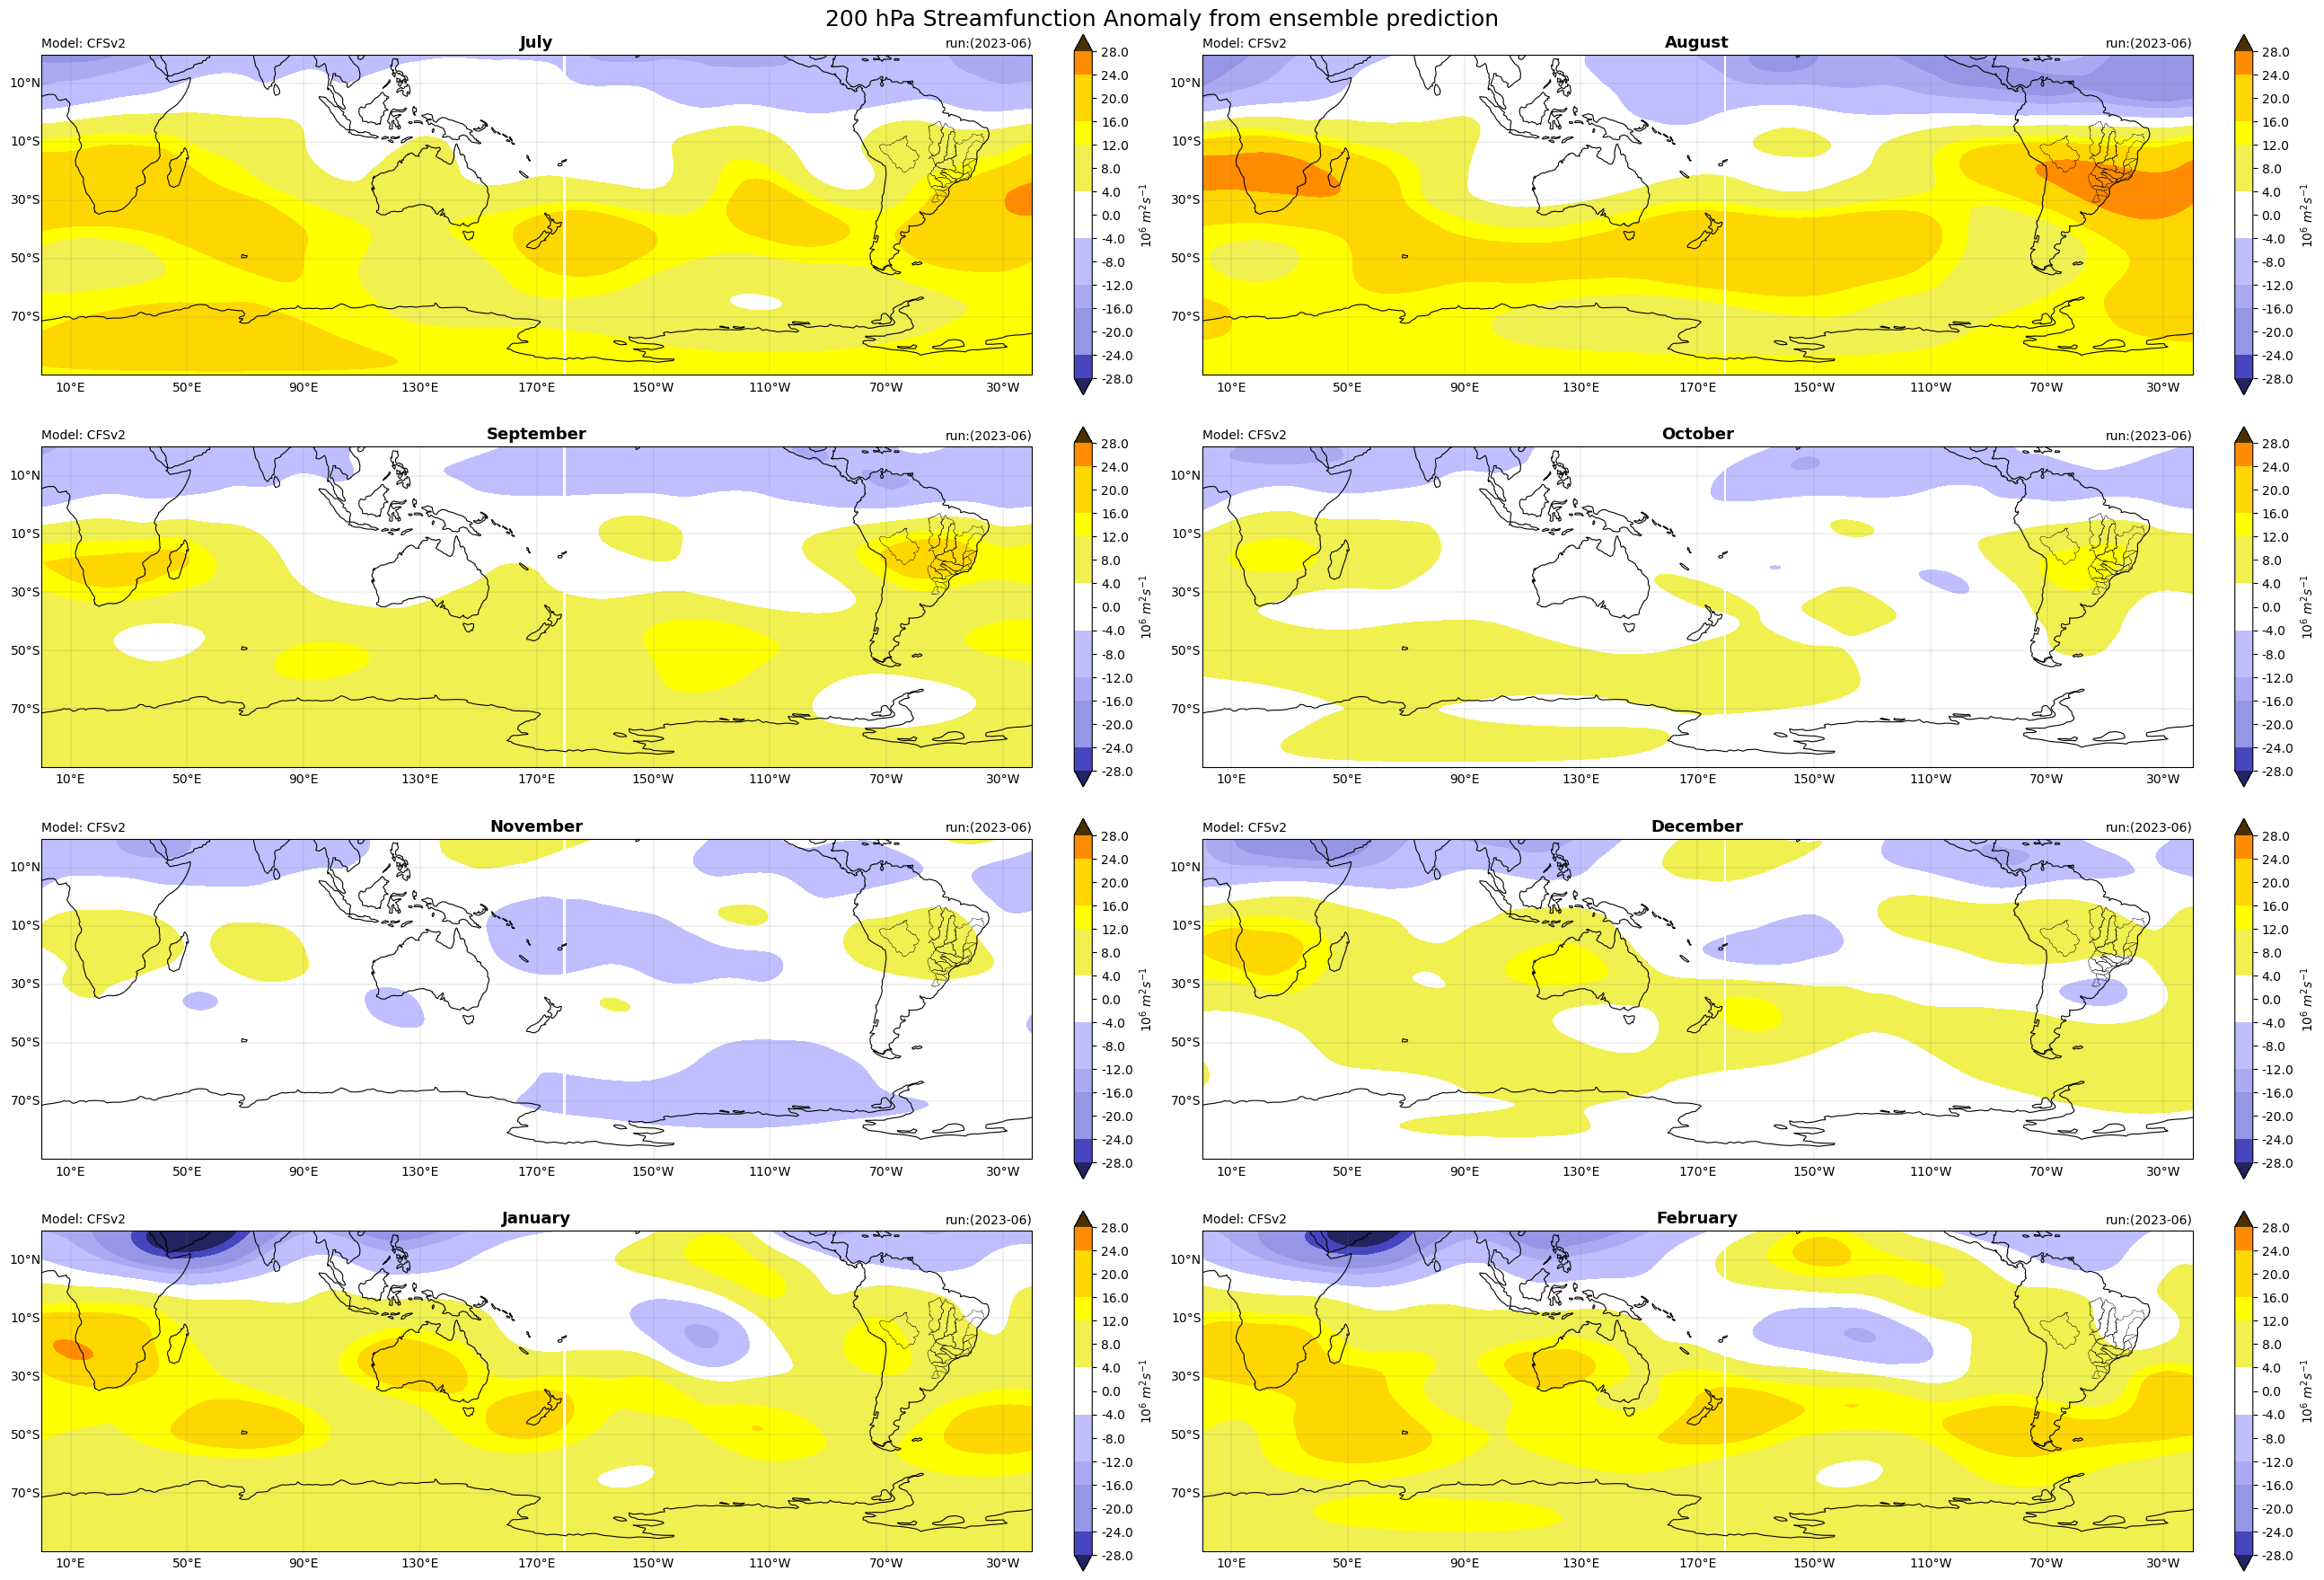

In [26]:

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(26, 18), sharex=False, subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
count = 0
fig.suptitle("200 hPa Streamfunction Anomaly from ensemble prediction", fontsize=18)

for i, a in zip(range(8), ax.ravel()):

    lon1 = 160
    lon2 = -180
    lats = 20
    latn = -110
    
    a.set_extent([lon1, lon2, lats, latn], crs=ccrs.PlateCarree(central_longitude=180))

    a.coastlines(color='black', linewidth=0.8)
    # a.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.3)

    gl = a.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      xlocs=np.arange(-150, 180, 40), ylocs=np.arange(-90, 40, 20),
                      x_inline=False, y_inline=False, linewidth=0.33, color='gray', alpha=0.5)
    gl.right_labels = False
    gl.top_labels = False

    colors = ['#4646be','#9696e6','#aaaaf2','#bfbfff','#ffffff','#ffffff','#f0f050','#ffff00','#ffd700', '#ff8c00']
        
              

    cmap = matplotlib.colors.ListedColormap(colors)

    cmap.set_over('#4c3100')
    cmap.set_under('#23235f')
    

    #------PSI

    # interval = 7
    # levels = np.arange(-28,30,interval)


    interval = 4
    levels = np.arange(-28,30,interval)


    cf = a.contourf(month_list_psi[count].longitude+180, month_list_psi[count].latitude, month_list_psi[count].strf*1e-6,levels=levels,cmap=cmap,extend='both')
    cb = plt.colorbar(cf, fraction=0.02,format='%.1f', pad=0.04,ticks=levels)
    cb.set_label('$10^{6}$ $m^{2}s^{-1}$',fontsize=10)


    

    # Loop para adicionar as geometrias das bacias
    for key in bacias:
        bacia_name = gpd.read_file(dir + '/shapes/bacias/' + key.lower().replace(' ', '_') + '-tok2.shp')
        a.add_geometries(bacia_name.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=0.25)

    
    a.set_title('Model: '+modelo_name[0],loc='left', fontsize=10)
    a.set_title(f"{month[count]}",fontweight='bold',fontsize=13)  #"{}".fomat(month[count])


    date_formatted_1 = data_atual.strftime('%Y-%m')
    a.set_title(f"run:({date_formatted_1})",fontsize=10,loc='right') 
 
    
    
    
    
    count += 1
    if count == len(month_list_psi):
           break
    


plt.tight_layout()
# plt.show()     

      
      
